Summary of classes, methods and attributes used in this demo:
* [`ROM`](#classes)
* [`POD`](#classes)
* [`POD.modes`](#classes)
* [`POD.kept_rank`](#ranks)
* [`POD.pod_coeff`](#coeffs)
* [`POD.project()`](#normalize)
* [`POD.inverse_project()`](#denormalize)
* [`ROM.normalize()`](#normalize)
* [`ROM.center()`](#normalize)
* [`ROM.denormalize()`](#denormalize)
* [`ROM.decenter()`](#denormalize)


In [1]:
import numpy as np
from rom_am.pod import POD
from rom_am.rom import ROM
import matplotlib.pyplot as plt

## Loading Data

As a numerical test for our implementation of the POD, we use as data simulation results (velocity and vorticity fields) for the wake behind a circular cylinder at a Reynolds number $Re = 100$.

The computational domain comprises $450 \times 200$ nodes, and the lengths are nondimensionalized by the cylinder diameter. The time step used is $\Delta t = 0.02 s$  and $150$ snapshots at regular intervals in time, $10\Delta t$, sampling five periods of vortex shedding.

In [2]:
import scipy.io
mat = scipy.io.loadmat('../DATA/Cylinder/CYLINDER_ALL.mat',) # Data could be downloaded from http://databookuw.com/DATA.zip
nx = 449
ny = 199
dt = .2
xx, yy = np.meshgrid(np.linspace(-1, 8, nx), np.linspace(-2, 2, ny))

def cylinder_clean_data(X, fill = 0):
    
    uu = X.reshape((ny, nx, -1), order = 'F')
    uu[(xx**2+yy**2)<.5**2, :] = fill
    
    return uu.reshape((ny*nx, -1), order = 'F')

def reshaping(X):
    
    return X.reshape((ny, nx), order = 'F')

cylinder_idx = (xx**2+yy**2)<.5**2

In [3]:
X = cylinder_clean_data(mat["UALL"])

# `rom_am` POD Reduction 101

\begin{equation}
\pmb{X}(t) = \sum_i^{r} \pmb{\Phi} \tilde{{x}}_i(t)
\end{equation}


where $\pmb{\Phi} \in \mathbb{R}^{N \times r}$  is the POD modes matrix and $\tilde{{x}}_i$ are the coordinates in the reduced $r$-d subspace.

---

<a id='classes'></a>
The `rom_am` package provides a framework for various non-intrusive model reduction methods.

The `ROM` class is the outer interface for the user to handle the reduction methods underneath.

The `POD` class we will see in this demo does the Proper Orthogonal Decomposition (POD) stuff.

An `ROM` object takes a `POD` object during its construction `rom = ROM(pod)`

The number of POD modes can be chosen through the argument `rank = `

In [4]:
chosen_rank = 7
pod = POD()
rom = ROM(pod)
rom.decompose(X, rank = chosen_rank)

---

## Modes

The $\pmb{\Phi}$ matrix is stored in `pod.modes`

In [5]:
pod.modes.shape

(89351, 7)

These modes can be visualized. We can see the spatial structures of the flow captured in some modes here.

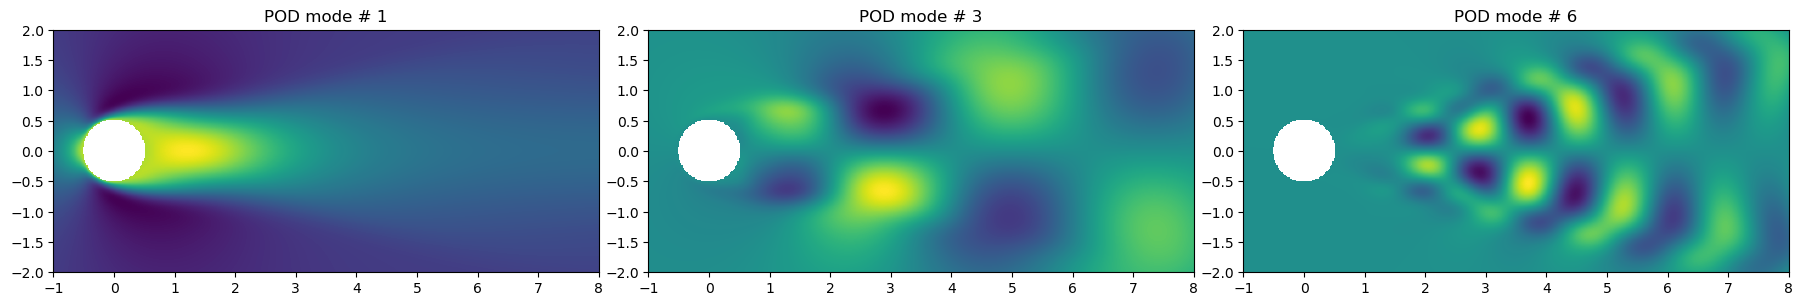

In [6]:
n_mode = [0, 2, 5]

fig, ax  = plt.subplots(1, 3, figsize = (18, 8))

for i in range(len(n_mode)):
    
    modes = cylinder_clean_data(pod.modes[:, n_mode[i]].copy(), np.nan)
    im = ax[i].imshow(reshaping(modes), extent=[-1, 8, -2, 2]);
    ax[i].set_title("POD mode # {}" .format(n_mode[i]+1));

fig.tight_layout();

---

## Centering

The `ROM` methods can perform additional preprocessing operations. For example, we can center the data around the mean. Using the argument `center = True`. We can see that the first mode that was representing this mean flow removed.

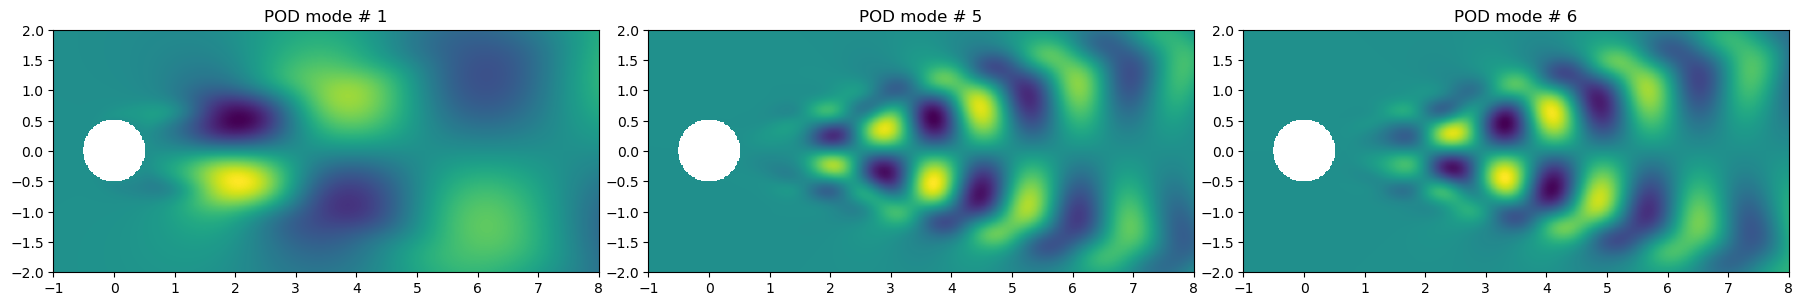

In [7]:
pod = POD()
rom = ROM(pod)
rom.decompose(X, rank = chosen_rank, center = True)
n_mode = [0, 4, 5]

fig, ax  = plt.subplots(1, 3, figsize = (18, 8))

for i in range(len(n_mode)):
    
    modes = cylinder_clean_data(pod.modes[:, n_mode[i]].copy(), np.nan)
    im = ax[i].imshow(reshaping(modes), extent=[-1, 8, -2, 2]);
    ax[i].set_title("POD mode # {}" .format(n_mode[i]+1));

fig.tight_layout();

---

Similarly, `normalize = True` is used for an $L_2$ normalization of the data before computing the POD.

In [8]:
pod = POD()
rom = ROM(pod)
rom.decompose(X, rank = chosen_rank, center = True, normalize = True)

We note that centering the data is done **before** the normalization.

---

## Energy-based choice of the number of modes

We can also show the energy stored in the POD reconstruction of the flow data using the singlar values of the snapshots.
$S = \frac{\sum_i^{r} \sigma_i^2}{\sum_i^d \sigma_i^2}$ :

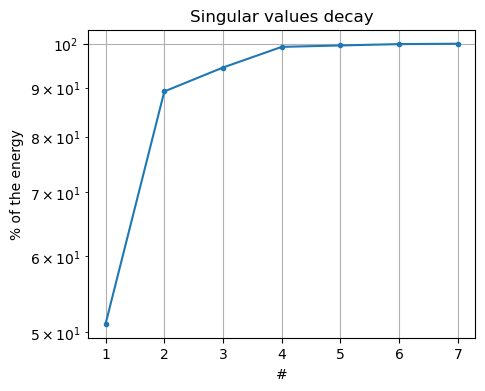

In [9]:
fig, ax = plt.subplots(figsize=(5, 4))
y = np.zeros(chosen_rank)
ranks = np.arange(chosen_rank)+1
ax.semilogy(ranks, 100*np.cumsum(pod.singvals[:chosen_rank]**2)/np.sum(pod.singvals[:chosen_rank]**2), '.-')
ax.grid();
ax.set_ylabel("% of the energy")
ax.set_xlabel("#");
ax.set_title("Singular values decay");


Instead of chosing a determined number of modes, you can choose an energy criteria that will determine the number of modes for you, i.e the percentage of energy embedded in the modes: 

\begin{equation}\label{energy_sing}
\begin{aligned}
\min_{r_u\in[1, d]} \quad & S = \frac{\sum_i^{r_u} \sigma_i^2}{\sum_i^d \sigma_i^2}\\
\textrm{s.t.} \quad &  S \leq \varepsilon\\
\end{aligned}
\end{equation}

This is the case when you choose `rank` as a float.

For example, choosing $99.99\%$ of the energy can be done in the following way:

In [10]:
pod = POD()
rom = ROM(pod)
rom.decompose(X, rank = .9999, center = True, normalize = True)

<a id='ranks'></a>
you can recover the actual number of modes :

In [11]:
pod.kept_rank

10

## The reduced coordinates

<a id='coeffs'></a>
The coordinates of the data on the reduced POD subspace can be retrieved using the attribute `pod_coeff`:

In [12]:
pod.pod_coeff.shape

(10, 151)

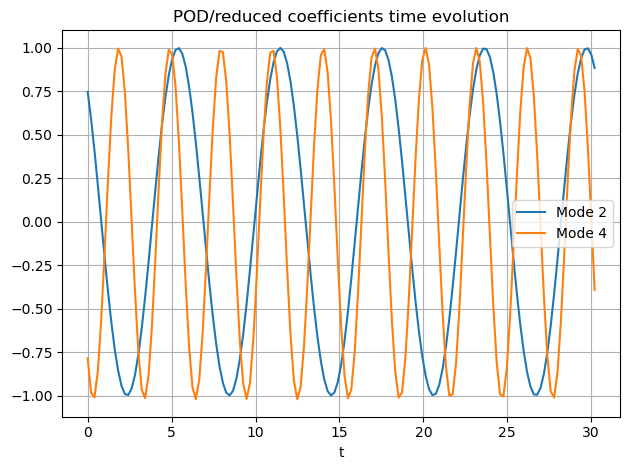

In [13]:
t = np.linspace(0, X.shape[1] * dt, X.shape[1])
fig = plt.figure()

plt.plot(t, pod.pod_coeff[1, :]/pod.pod_coeff[1, :].max(), label = "Mode 2")
plt.plot(t, pod.pod_coeff[3, :]/pod.pod_coeff[3, :].max(), label = "Mode 4")

plt.grid();
plt.title("POD/reduced coefficients time evolution");
plt.xlabel("t");
plt.legend(loc = "best");
plt.tight_layout();

## Encoding - Orthogonal projection

For new data, an orthogonal projection on the POD subspace can be computed to get the reduced coordinates 

\begin{equation}
\tilde{x}=\pmb{\Phi}^T \pmb{X}
\end{equation}

In our case, and in the absence of new data, we will use the available snapshots **`X`** as new data

<a id='normalize'></a>
* First a centering of these new data should be done through `rom.center()`
* Second a normalization should be done through `rom.normalize()`:


In [14]:
newData = X.copy()
newnormalized_data = rom.normalize(rom.center(newData))
reduced_coors = pod.project(newnormalized_data)

In [15]:
np.allclose(reduced_coors, pod.pod_coeff, rtol = 1e-10)

True

## Encoding - Inverse projection

For new reduced coordiantes, we can recontruct the high-dimensional solution using POD modes

\begin{equation}
\pmb{X}=\pmb{\Phi}\tilde{x}
\end{equation}

<a id='denormalize'></a>
* First, denormalization of the data should be done through `rom.denormalize()`
* Second a decentering of the new data should be done through `rom.decenter()`

In [16]:
newReduced_coors = pod.pod_coeff.copy()
reconsData = pod.inverse_project(newReduced_coors)
denormalizedData = rom.decenter(rom.denormalize(reconsData))
rel_error = np.linalg.norm(denormalizedData - X)/np.linalg.norm(X)

In [17]:
print("The ",pod.kept_rank,"-mode POD reconstruction error is, ", 100*rel_error, "%")

The  10 -mode POD reconstruction error is,  0.10807297315970177 %
